# Contingency analysis of the scigrid of Germany

In [3]:
import pypsa, os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline
import cartopy.crs as ccrs
from pypsa.descriptors import get_switchable_as_dense as as_dense

%load_ext autoreload
%autoreload 2

### Load the scigrid network of `Germany`

In [4]:
n = pypsa.examples.scigrid_de(from_master=True)
#n.plot()

INFO:pypsa.io:Imported network scigrid-de.nc has buses, generators, lines, loads, storage_units, transformers


In [45]:
n.passive_branches

<bound method Network.passive_branches of PyPSA Network 'scigrid-de'
Components:
 - Bus: 585
 - Generator: 1423
 - Line: 852
 - Load: 489
 - StorageUnit: 38
 - Transformer: 96
Snapshots: 24>

### Increase the lines `s_nom` to acceptable values, i.e. `1.2 GW`

In [3]:
for line_name in ["316", "527", "602"]:
    n.lines.loc[line_name, "s_nom"] = 1200

<Axes: xlabel='Line'>

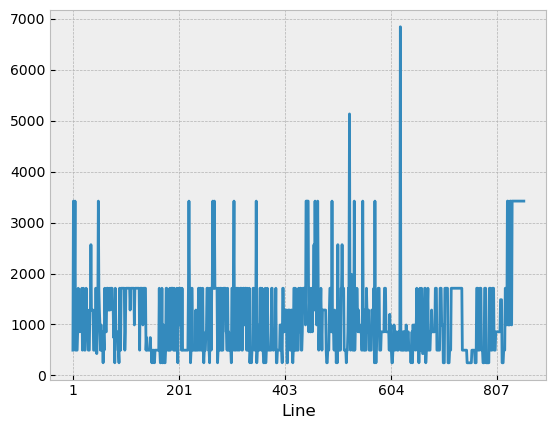

In [4]:
n.lines['s_nom'].plot()

### Sort the lines in descending order according to the `s_nom` parameter, and load them to a new pandas df

In [5]:
lines = n.lines.sort_values(by=['s_nom'], ascending=False)

<Axes: xlabel='Line'>

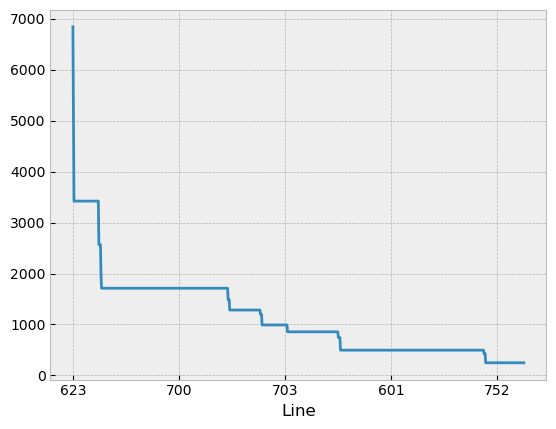

In [6]:
lines['s_nom'].plot()

### Remove the lines causing N-1 infeasibility from the new df lines

In [9]:
lines.loc(axis=0)['551', '553', '535', '465', '504', '349']

KeyError: "None of [Index(['551', '553', '535', '465', '504', '349'], dtype='object', name='Line')] are in the [index]"

In [8]:
lines.drop(['551', '553', '535', '465', '504', '349'], inplace=True)

### Plot the load curve of Jan. the 1st 2011, and select one hour where N-1 contingency is calculated 

<Axes: xlabel='snapshot'>

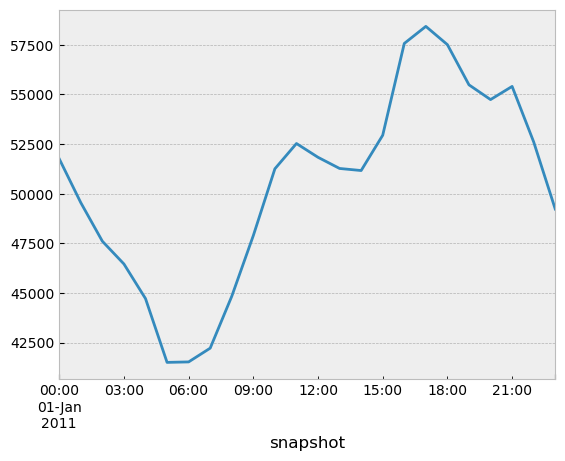

In [42]:
n.loads_t.p_set.T.sum(axis=0).plot()

In [11]:
now = n.snapshots[10]

In [41]:
len(n.snapshots)

24

### Make a selection of the first 25 lines with the highest s_nom for the contingency analysis

In [158]:
lines[:50].index

Index(['623', '526', '859', '833', '828', '827', '49', '574', '493', '460',
       '835', '447', '446', '445', '444', '443', '2', '305', '268', '265',
       '834', '220', '837', '858', '857', '5', '851', '842', '856', '843',
       '844', '845', '846', '855', '847', '848', '838', '849', '854', '853',
       '852', '841', '850', '839', '840', '512', '458', '35', '530', '378'],
      dtype='object', name='Line')

In [12]:
br_out = lines.iloc[:25].index

<Axes: xlabel='carrier,Generator'>

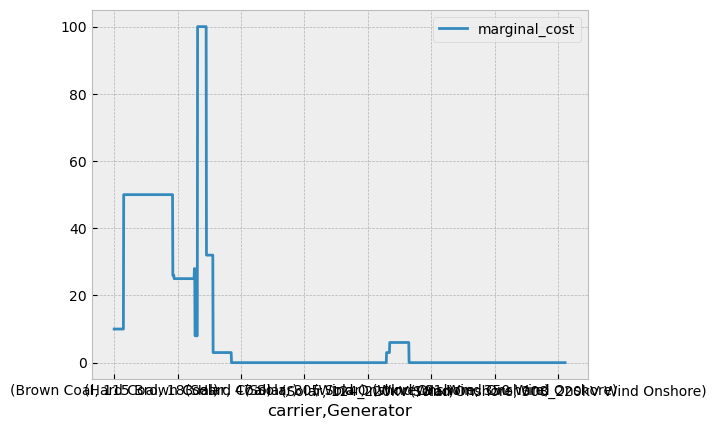

In [43]:
n.generators.groupby("carrier", group_keys=True)[['marginal_cost']].apply(lambda y:y).

### Solver settings & solving the N-1 scigrid network

In [13]:
solver_options = {'threads': 8, 'parallel': 'on'}

In [20]:
n.optimize.optimize_security_constrained(
    now, branch_outages=br_out, solver_name="cbc", solver_options = solver_options
)

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - threads: 8
 - parallel: on
INFO:linopy.io: Writing time: 0.27s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 



### For the PF, set the P to the optimised P

In [21]:
n.generators_t.p_set = n.generators_t.p_set.reindex(
    columns=n.generators.index
)
n.generators_t.p_set.loc[n.snapshots[10]] = n.generators_t.p.loc[n.snapshots[10]]

n.storage_units_t.p_set = n.storage_units_t.p_set.reindex(
    columns=n.storage_units.index
)
n.storage_units_t.p_set.loc[n.snapshots[10]] = n.storage_units_t.p.loc[n.snapshots[10]]

### Check no lines are overloaded with the linear contingency analysis

In [22]:
p0_test = n.lpf_contingency(n.snapshots[10], branch_outages=br_out)

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-01-01 10:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)


In [23]:
p0_test

base  (Line, 623)  (Line, 526)   (Line, 859)  \
Line        1    -114.727051  -114.727051  -114.727051 -1.147271e+02   
            2     406.740562   406.740562   420.319954  4.062356e+02   
            3     354.195129   354.195129   358.178410  3.541492e+02   
            4    -870.199344  -870.199344  -884.683791 -8.699470e+02   
            5     607.016081   607.016081   608.232742  6.069148e+02   
            6      15.782790    15.782790    17.000735  1.576871e+01   
            7      68.908090    68.908090    70.126035  6.889401e+01   
            8      52.517375    52.517375    53.824080  5.250227e+01   
            9     -85.865242   -85.865242   -73.698748 -8.591823e+01   
            10   -215.376695  -215.376695   -96.722722 -2.155107e+02   
            11   1222.648743  1222.648743  1246.056907  1.222323e+03   
            12   -380.710655  -380.710655  -376.641233 -3.807543e+02   
            13    360.359173   360.359173   356.289752  3.604028e+02   
            14   -215.143703  -215.143703   -96.618088 -2.152775e+02   
            15     40.492852    40.492852   245.755463  4.046316e+01   
            16    -86.741751   -86.741751   -86.741751 -8.674175e+01   
            17    -57.165950   -57.165950   -58.623329 -5.715639e+01   
            18   -421.822332  -421.822332  -421.093666 -4.218271e+02   
            19    192.773818   192.773818   194.232071  1.927643e+02   
            20    165.041730   165.041730   165.086674  1.650414e+02   
            21   -178.817322  -178.817322  -178.942892 -1.788165e+02   
            22   -821.238821  -821.238821  -822.566980 -8.212301e+02   
            23    -39.534936   -39.534936   -38.816309 -3.953965e+01   
            24    -54.227756   -54.227756   -54.925495 -5.422318e+01   
            25    749.790532   749.790532   758.125523  7.497359e+02   
            26    312.325871   312.325871   312.934106  3.122753e+02   
            27   -143.121120  -143.121120  -144.619793 -1.431113e+02   
            28  -1001.878131 -1001.878131 -1039.974375 -1.001716e+03   
            29    974.690360   974.690360  1012.458259  9.745295e+02   
            30    -96.123307   -96.123307   -96.123307 -9.612331e+01   
            31    -90.394608   -90.394608   -90.394608 -9.039461e+01   
            32   -119.177736  -119.177736  -123.276021 -1.190730e+02   
            33    -80.708844   -80.708844   -86.266128 -8.065913e+01   
            34    197.549022   197.549022   203.844389  1.974927e+02   
            35    -40.879760   -40.879760   -47.175127 -4.082345e+01   
            36   -266.464232  -266.464232  -264.471474 -2.664903e+02   
            37   -669.647179  -669.647179  -664.263805 -6.697129e+02   
            38   -298.852463  -298.852463  -304.235836 -2.987868e+02   
            39    204.133409   204.133409   208.367223  2.040847e+02   
            40   -154.580384  -154.580384  -154.580384 -1.545804e+02   
            41   -154.754543  -154.754543  -154.754543 -1.547545e+02   
            42   -198.567430  -198.567430  -200.480871 -1.985477e+02   
            43     13.239437    13.239437    15.145166  1.321974e+01   
            44   -814.253542  -814.253542  -812.339025 -8.142733e+02   
            45   -813.345044  -813.345044  -811.432663 -8.133648e+02   
            46    174.968899   174.968899   174.968899  1.749689e+02   
            47   -170.229406  -170.229406  -170.229406 -1.702294e+02   
            48  -1016.320084 -1016.320084 -1054.087983 -1.016159e+03   
            49    451.367238   451.367238   480.531388  4.492170e+02   
            50    173.357798   173.357798   177.288565  1.733394e+02   
            51   -476.820571  -476.820571  -474.159901 -4.769594e+02   
            52     59.154175    59.154175    59.154175  5.915417e+01   
            53    -94.078333   -94.078333   -98.834212 -9.413853e+01   
            54   -228.653474  -228.653474  -228.653474 -2.286535e+02   
            55     47.775408    47.775408    47.775408  4.777541

In [107]:
lines[(lines.index=='273')]

,bus0,bus1,c_nfkm,cables,frequency,from_relation,i_th_max_a,length,length_m,num_parallel,operator,osm_name,r_ohmkm,ref,s_nom,type,voltage,wires,wkt_srid_4326,x_ohmkm,x,r,g,b,s_nom_mod,s_nom_extendable,s_nom_min,s_nom_max,s_max_pu,capital_cost,build_year,lifetime,carrier,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
273,212,99,13.7,3.0,NaN,1636708.0,2.6,48.829,48829.0,1.0,Amprion,Uchtelfangen Ost,0.025,,1711.266198,Al/St 240/40 4-bundle 380.0,380000.0,4.0,SRID=4326;LINESTRING(6.81368431456473 49.72483...,0.25,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check loading as per unit of s_nom in each contingency

In [64]:
max_loading = (
    abs(p0_test.divide(n.passive_branches().s_nom, axis=0)).describe().loc["max"]
)
max_loading

base           1.0
(Line, 623)    1.0
(Line, 526)    1.0
(Line, 859)    1.0
(Line, 833)    1.0
(Line, 828)    1.0
(Line, 827)    1.0
(Line, 49)     1.0
(Line, 574)    1.0
(Line, 493)    1.0
(Line, 460)    1.0
(Line, 835)    1.0
(Line, 447)    1.0
(Line, 446)    1.0
(Line, 445)    1.0
(Line, 444)    1.0
(Line, 443)    1.0
(Line, 2)      1.0
(Line, 305)    1.0
(Line, 268)    1.0
(Line, 265)    1.0
(Line, 834)    1.0
(Line, 220)    1.0
(Line, 837)    1.0
(Line, 858)    1.0
(Line, 857)    1.0
Name: max, dtype: float64

In [25]:
np.allclose(max_loading, np.ones((len(max_loading))))

True

<Axes: >

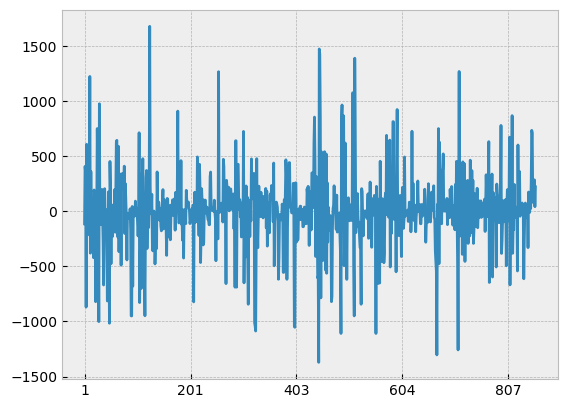

In [192]:
n.lines_t['p0'].loc[now].plot()

## Cells below irrelevant for the time being 

In [69]:
n.buses_t.marginal_price.loc[[now], :]

Bus,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,409,410,411,412,413,414,415,416,417,418,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,2_220kV,5_220kV,10_220kV,12_220kV,13_220kV,15_220kV,18_220kV,20_220kV,22_220kV,24_220kV,26_220kV,30_220kV,32_220kV,37_220kV,42_220kV,46_220kV,52_220kV,56_220kV,61_220kV,68_220kV,69_220kV,74_220kV,78_220kV,86_220kV,87_220kV,94_220kV,95_220kV,96_220kV,99_220kV,100_220kV,104_220kV,105_220kV,106_220kV,107_220kV,117_220kV,120_220kV,123_220kV,124_220kV,125_220kV,128_220kV,129_220kV,138_220kV,143_220kV,156_220kV,157_220kV,159_220kV,160_220kV,165_220kV,184_220kV,191_220kV,195_220kV,201_220kV,220_220kV,231_220kV,232_220kV,233_220kV,236_220kV,247_220kV,248_220kV,250_220kV,251_220kV,252_220kV,261_220kV,263_220kV,264_220kV,267_220kV,272_220kV,279_220kV,281_220kV,282_220kV,292_220kV,303_220kV,307_220kV,308_220kV,312_220kV,315_220kV,317_220kV,322_220kV,332_220kV,334_220kV,336_220kV,338_220kV,351_220kV,353_220kV,360_220kV,362_220kV,382_220kV,384_220kV,385_220kV,391_220kV,403_220kV,404_220kV,413_220kV,421_220kV,450_220kV,458_220kV
snapshot,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 10:00:00,-3.44391,-4.511401,-9.200962,-4.5188,0.639694,3.630589,-3.129865,0.307865,0.374806,2.678301,2.79826,2.79352,23.949047,23.693894,23.614504,5.072561,2.608713,1.083448,23.874948,0.024339,0.071303,0.000086,-0.002855,-0.000004,0.001023,0.000893,-0.056871,-0.027135,0.435577,-0.091903,24.557632,14.31277,19.991899,5.423411,5.423411,5.423411,0.420043,1.949689,0.468415,0.94588,0.511116,0.587256,2.79634,3.090207,3.475107,2.839823,2.839823,2.839823,8.273645,8.273645,30.095181,23.679765,23.708014,23.621322,23.659316,23.425596,23.659316,23.659316,3.750427,5.278469,2.323801,0.361612,23.677642,23.949047,12.694226,

<Axes: xlabel='snapshot'>

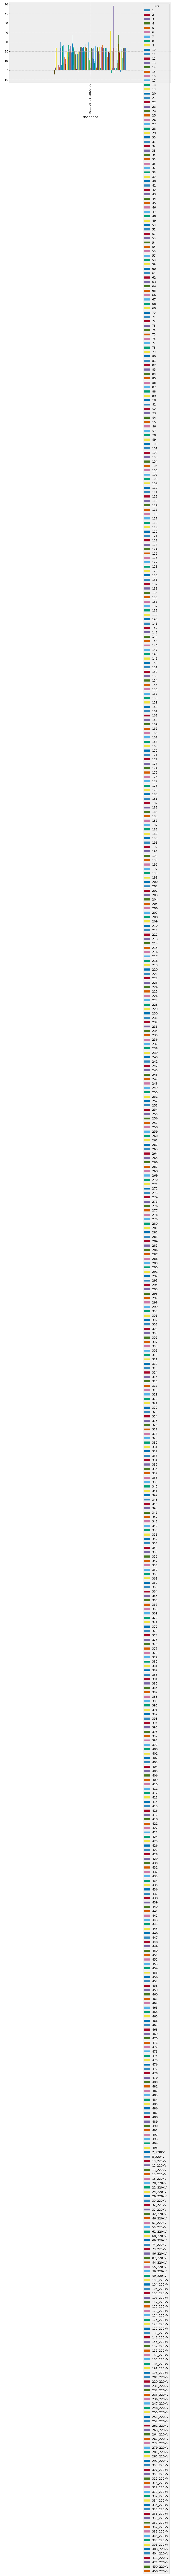

In [39]:
n.buses_t.marginal_price.loc[[now], :].plot.bar(width=.4, figsize=(10,5))

In [393]:
lines.iloc[5:15]

,bus0,bus1,c_nfkm,cables,frequency,from_relation,i_th_max_a,length,length_m,num_parallel,operator,osm_name,r_ohmkm,ref,s_nom,type,voltage,wires,wkt_srid_4326,x_ohmkm,x,r,g,b,s_nom_mod,s_nom_extendable,s_nom_min,s_nom_max,s_max_pu,capital_cost,build_year,lifetime,carrier,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
828,351,353,NaN,6.0,NaN,NaN,NaN,6.767298,NaN,2.0,,,NaN,,3422.532396,Al/St 240/40 4-bundle 380.0,380000.0,4.0,,NaN,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
827,384,351,NaN,6.0,NaN,NaN,NaN,105.026711,NaN,2.0,,,NaN,,3422.532396,Al/St 240/40 4-bundle 380.0,380000.0,4.0,,NaN,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,31,51,27.4,6.0,NaN,270963.0,5.2,40.647000,40647.0,2.0,TenneT,3009 Borken - Mecklar,0.0125,3009,3422.532396,Al/St 240/40 4-bundle 380.0,380000.0,4.0,SRID=4326;LINESTRING(9.74615081640288 50.91683...,0.125,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574,220,76,27.4,6.0,NaN,3873611.0,5.2,32.023000,32023.0,2.0,TenneT,Bechterdissen - Elsen,0.0125,,3422.532396,Al/St 240/40 4-bundle 380.0,380000.0,4.0,SRID=4326;LINESTRING(8.65937290290079 51.99961...,0.125,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551,99,360,27.4,6.0,NaN,3803495.0,5.2,23.317000,23317.0,2.0,,Uchtelfangen - Ensdorf,0.0125,,3422.532396,Al/St 240/40 4-bundle 380.0,380000.0,4.0,SRID=4326;LINESTRING(6.99647659179489 49.37540...,0.125,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
535,359,360,27.4,6.0,NaN,3756990.0,5.2,40.228000,40228.0,2.0,,Ensdorf (DE) - Vigy (FR),0.0125,,3422.532396,Al/St 240/40 4-bundle 380.0,380000.0,4.0,SRID=4326;LINESTRING(6.27694178519793 49.19774...,0.125,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
493,332,337,27.4,6.0,NaN,3732390.0,5.2,63.598000,63598.0,2.0,,,0.0125,451;452,3422.532396,Al/St 240/40 4-bundle 380.0,380000.0,4.0,SRID=4326;LINESTRING(13.1034346393158 48.66679...,0.125,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460,13,314,27.4,6.0,NaN,3710278.0,5.2,50.049000,50049.0,2.0,,,0.0125,419;420,3422.532396,Al/St 240/40 4-bundle 380.0,380000.0,4.0,SRID=4326;LINESTRING(11.3704262486892 48.29149...,0.125,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,2,296,NaN,6.0,NaN,NaN,NaN,0.271835,NaN,2.0,,,NaN,,3422.532396,Al/St 240/40 4-bundle 380.0,380000.0,4.0,,NaN,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
n.iterate_components

<bound method Network.iterate_components of PyPSA Network 'scigrid-de'
Components:
 - Bus: 585
 - Generator: 1423
 - Line: 852
 - Load: 489
 - StorageUnit: 38
 - Transformer: 96
Snapshots: 24>

In [186]:
type(n)

pypsa.components.Network

In [8]:
n.snapshots

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               '2011-01-01 12:00:00', '2011-01-01 13:00:00',
               '2011-01-01 14:00:00', '2011-01-01 15:00:00',
               '2011-01-01 16:00:00', '2011-01-01 17:00:00',
               '2011-01-01 18:00:00', '2011-01-01 19:00:00',
               '2011-01-01 20:00:00', '2011-01-01 21:00:00',
               '2011-01-01 22:00:00', '2011-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)

In [190]:
for line_name in ["316", "527", "602"]:
    print(n.lines.loc[line_name].s_nom)


495.366530965
855.633098939
495.366530965


In [62]:
len(n.lines)

852

In [63]:
len(n.lines.index)

852

In [9]:
n.lines.index[650:751]

Index(['657', '658', '659', '660', '661', '662', '663', '664', '665', '666',
       ...
       '748', '749', '750', '751', '752', '753', '754', '755', '756', '757'],
      dtype='object', name='Line', length=101)

In [124]:
branch_out = n.lines.sort_values('s_nom').iloc[125:150].index

In [194]:
br_out

Index(['459', '470', '48', '51', '453', '449', '676', '68', '69', '666'], dtype='object', name='Line')

In [68]:
n.sclopf(n.snapshots[23], branch_outages=br_out, keep_files=True, pyomo=False, solver_name='cbc', solver_options=solver_options)

INFO:pypsa.linopf:Prepare linear problem


INFO:pypsa.linopf:Total preparation time: 53.17s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.87e+05


### Cells above irrelevant for the time being

## The system runcost whilst meeting the N-1 criteria

In [42]:
n.objective

196769.28876712

# Calsulate the base case LOPF for the scigrid, i.e. ignore the N-1 critera

<ul>
<li>obtain the <b>objective function value</b></li>
<li>calculate the <b>line loadings</b></li>
<li>calculate the <b>trafo loading</b></li>
<li>get the <b>fuel mix</b> under the optimal conditions</li>
</ul>

In [43]:
o = pypsa.examples.scigrid_de(from_master=True)

INFO:pypsa.io:Imported network scigrid-de.nc has buses, generators, lines, loads, storage_units, transformers


In [44]:
o.optimize(o.snapshots[10], solver_name = 'cbc', solver_options=solver_options)

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')


Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - threads: 8
 - parallel: on
INFO:linopy.io: Writing time: 0.14s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 



('ok', 'optimal')

In [45]:
o.objective

134749.07956638

## Objective function conmparison between N-1 & the optimal run
<ul>
<li>N-1 objective: 196.77 K EUR/h</li>
<li>OPF objective: 134.75 K EUR/h</li>
</ul>

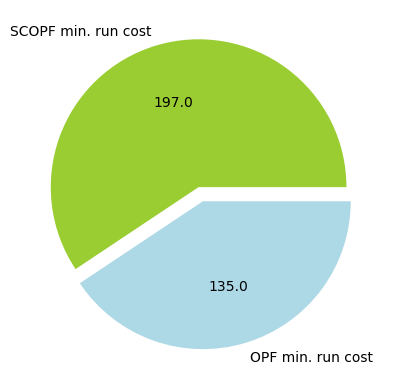

In [46]:
objectives = np.array([n.objective, o.objective])
def absolute_value(val):
    a  = np.round(val/100000.*objectives.sum(), 0)
    return a

plt.pie(objectives, labels = ['SCOPF min. run cost', 'OPF min. run cost'], colors = ['yellowgreen', 'lightblue'], explode = [.05, .05], autopct = absolute_value)
plt.show()

## Let's go ahead & try to compare the line loadings under base case N-1 calc. and optimal flow
<ul>
<li><b>also calculate the average flows across all the lines & compare the two</b></li>
</ul>

In [47]:
x = n.lines.index.to_numpy(dtype='float64')

In [48]:
y = n.lines_t.p0.loc[now].to_numpy(dtype='float64')

In [49]:
z = o.lines_t.p0.loc[now].to_numpy(dtype='float64')

In [96]:
n.lines_t.p0.loc[now].where(n.lines_t.p0.loc[now] > 0).mean(0)

206.84442903814744

In [95]:
n.lines_t.p0.loc[now].where(n.lines_t.p0.loc[now] < 0).mean(0)

-229.10339336640374

In [97]:
o.lines_t.p0.loc[now].where(o.lines_t.p0.loc[now] > 0).mean(0)

207.4713740679476

In [98]:
o.lines_t.p0.loc[now].where(o.lines_t.p0.loc[now] < 0).mean(0)

-248.2995915014137

## Ovreall system line flows

### Slightly less (in asb. value) average negative flows, across the system for N-1 basecase vs. LOPF.
### For positive average flows basically one line is over the other, averaged flows are the same, although they differ looking at individual lines.

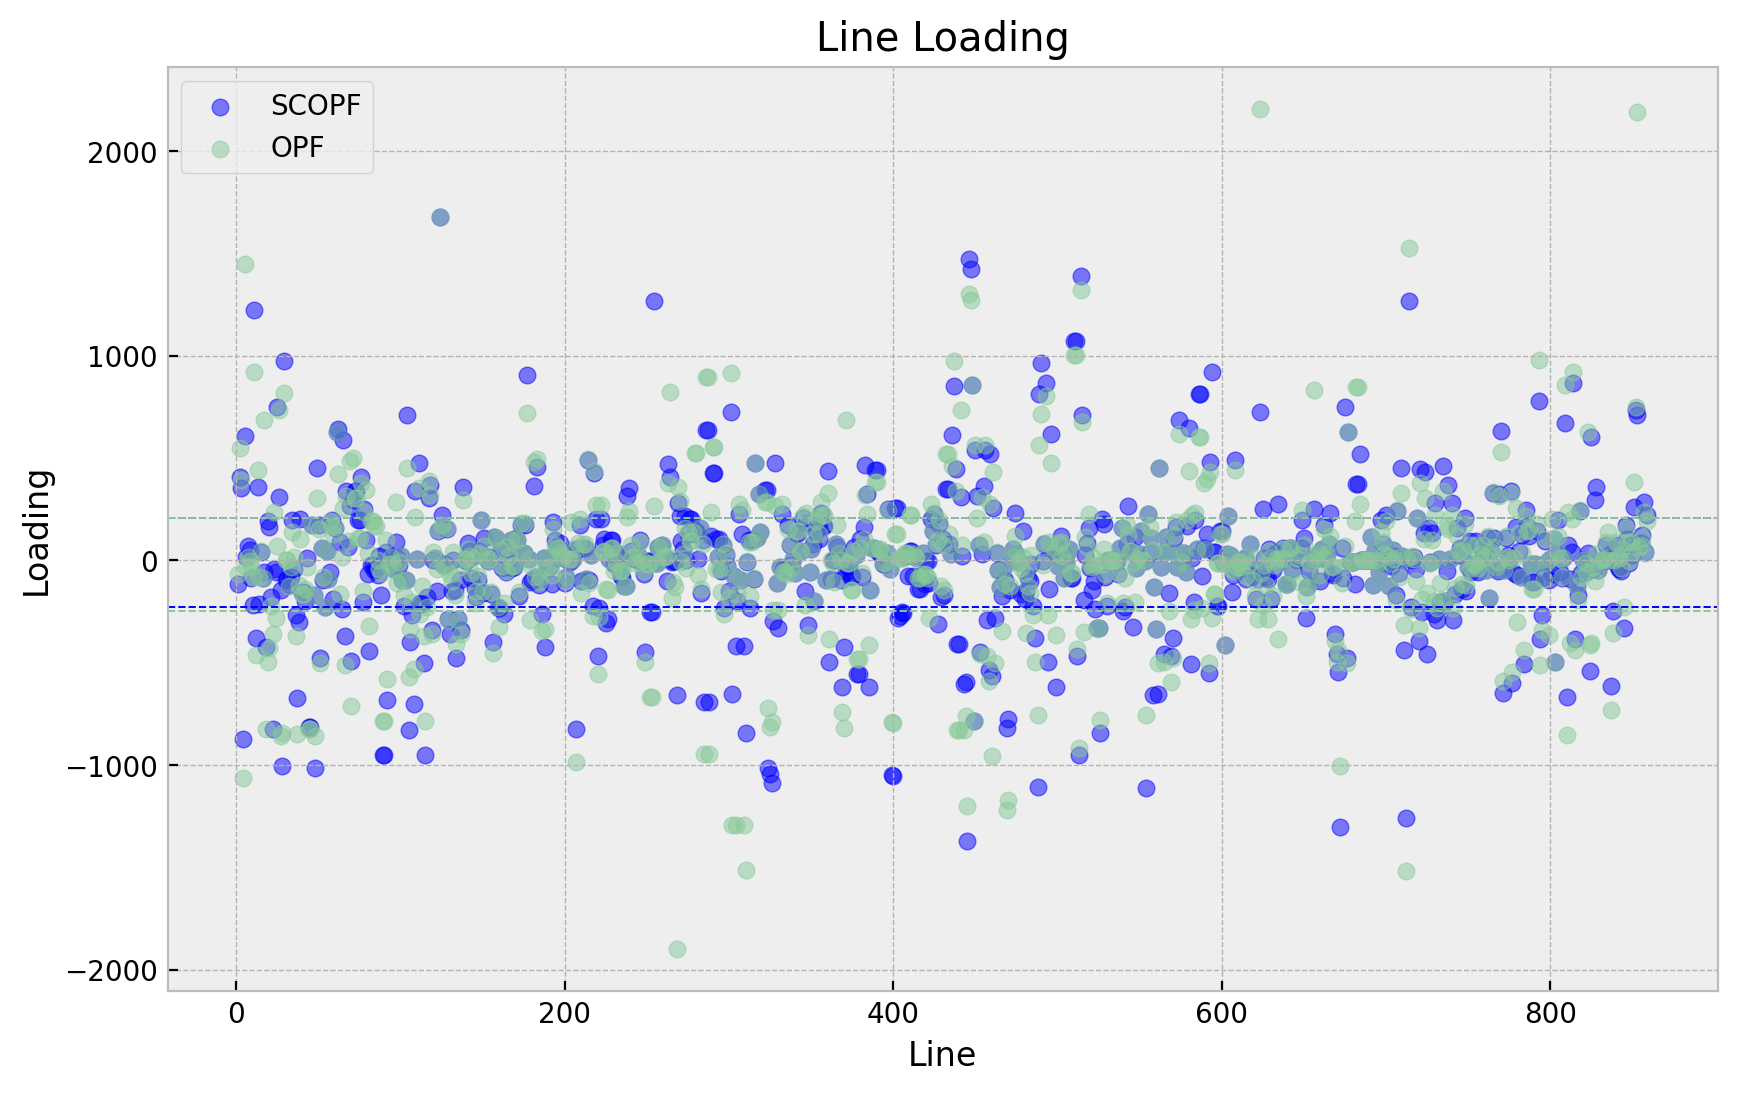

In [103]:
plt.figure(figsize=(10, 6), dpi = 200)

x = n.lines.index.to_numpy(dtype='float64')
y = n.lines_t.p0.loc[now].to_numpy(dtype='float64')
z = o.lines_t.p0.loc[now].to_numpy(dtype='float64')

plt.title("Line Loading")
plt.xlabel("Line")
plt.ylabel("Loading")

plt.scatter(x, y, c = 'b', alpha=0.5, label = 'SCOPF')
plt.scatter(x, z, c = '#88c999', alpha=0.5, label = 'OPF')
plt. axhline(y = 206.84442903814744, color = 'b', linestyle = '--', linewidth = .7)
plt. axhline(y = -229.10339336640374, color = 'b', linestyle = '--', linewidth = .7)
plt. axhline(y = 207.4713740679476, color = '#88c999', linestyle = '--', linewidth = .7)
plt. axhline(y = -248.2995915014137, color = '#88c999', linestyle = '--', linewidth = .7)

plt.legend()
plt.show()

## Let's now focus only on the fows of the lines considered by the N-1 criteria

### A bigger difference between the N-1 and LOPF, of the averaged flows across these lines is expected, and this is what is observed. This is primarily due to a couple of outliers/high flows occuring in the LOPF scenario, compared to the N-1 base case.
### This is specificaly obvious for the negative flows: line 268.
### However, a small difference is there aslo, in the average values, for the positive flows as well: the highest flow difference is for line 623.

In [51]:
br_out

Index(['623', '526', '859', '833', '828', '827', '49', '574', '493', '460',
       '835', '447', '446', '445', '444', '443', '2', '305', '268', '265',
       '834', '220', '837', '858', '857'],
      dtype='object', name='Line')

In [52]:
xx = br_out.to_numpy(dtype='float64')

In [53]:
n.lines_t.p0.loc[[now] , br_out]

Line,623,526,859,833,828,827,49,574,493,460,835,447,446,445,444,443,2,305,268,265,834,220,837,858,857
snapshot,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 10:00:00,725.51965,-844.343675,221.464338,-3.057497,360.357546,296.784252,451.367238,688.33353,865.170461,-563.161341,25.310565,1426.324139,1472.073458,-1371.389799,-592.642839,-605.092799,406.740562,-198.371036,-657.188319,-6.97845,74.408163,-465.866404,-612.956708,40.717764,285.066413


In [74]:
n.lines_t.p0.loc[[now] , br_out].where(n.lines_t.p0.loc[[now] , br_out]>0).mean(1)

snapshot
2011-01-01 10:00:00    524.259863
dtype: float64

In [75]:
n.lines_t.p0.loc[[now] , br_out].where(n.lines_t.p0.loc[[now] , br_out]<0).mean(1)

snapshot
2011-01-01 10:00:00   -538.27717
dtype: float64

In [76]:
o.lines_t.p0.loc[[now] , br_out].where(o.lines_t.p0.loc[[now] , br_out]>0).mean(1)

snapshot
2011-01-01 10:00:00    556.077279
dtype: float64

In [77]:
o.lines_t.p0.loc[[now] , br_out].where(o.lines_t.p0.loc[[now] , br_out]<0).mean(1)

snapshot
2011-01-01 10:00:00   -741.090729
dtype: float64

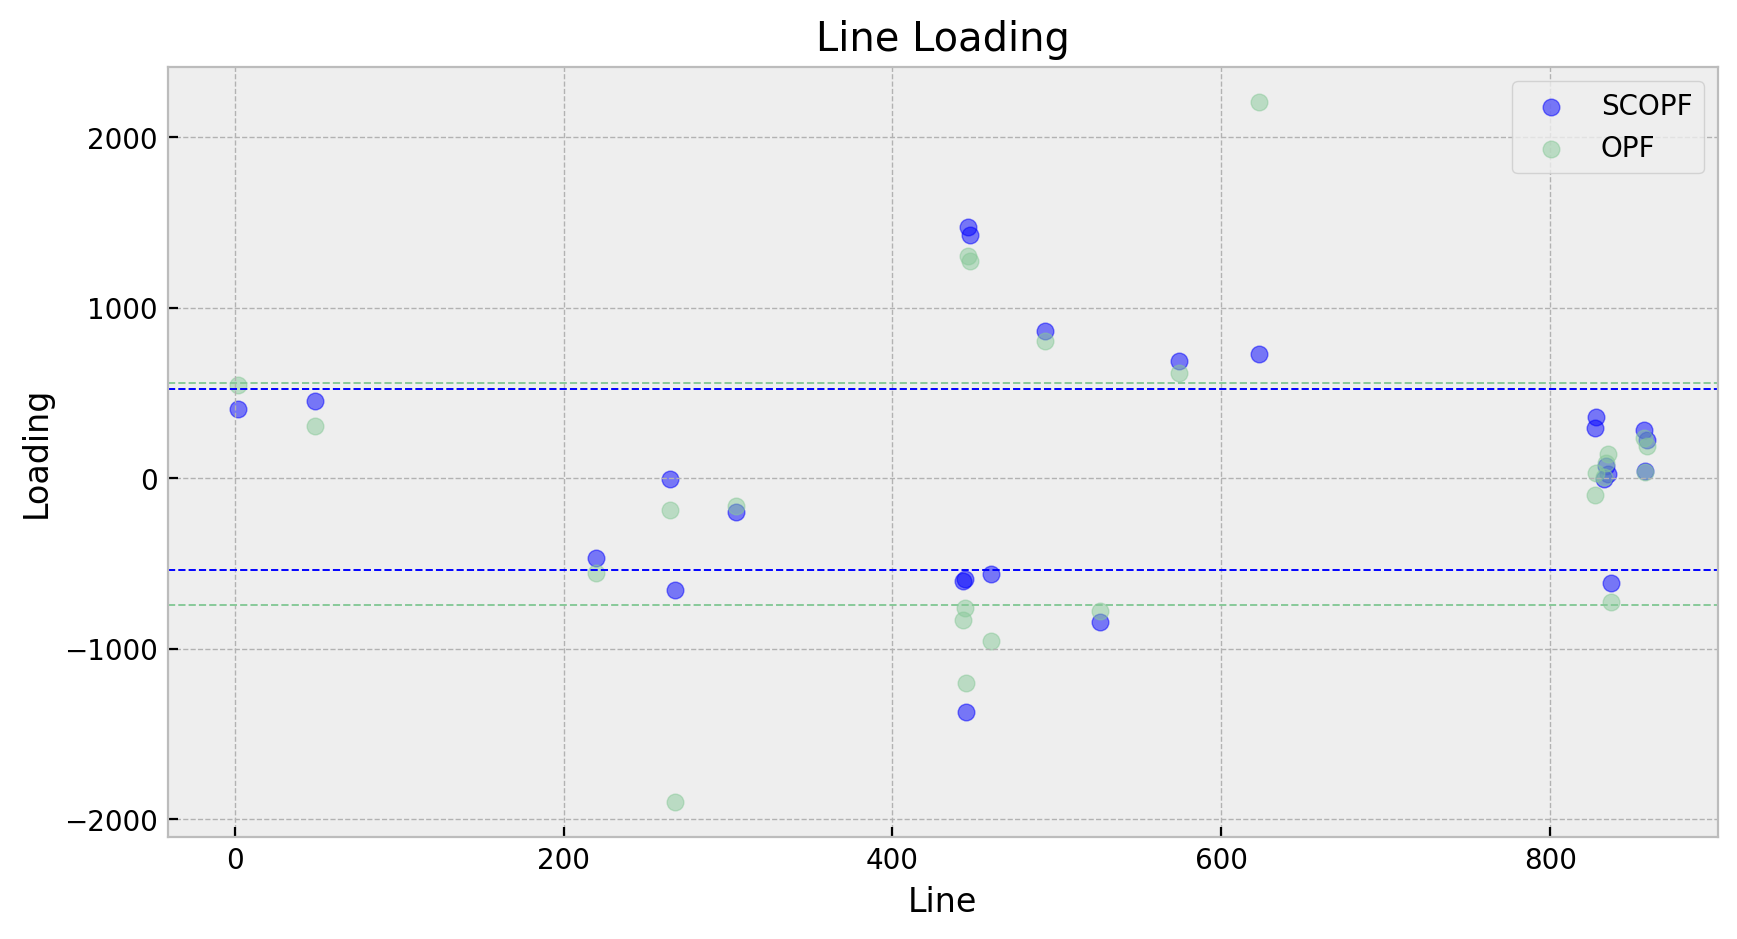

In [93]:
plt.figure(figsize=(10, 5), dpi=200)

xx = br_out.to_numpy(dtype='float64')
yy = n.lines_t.p0.loc[[now] , br_out].to_numpy(dtype='float64')
zz = o.lines_t.p0.loc[[now] , br_out].to_numpy(dtype='float64')

plt.title("Line Loading")
plt.xlabel("Line")
plt.ylabel("Loading")

plt.scatter(xx, yy, c = 'b', alpha = 0.5, label = 'SCOPF')
plt.scatter(xx, zz, c = '#88c999', alpha = 0.5, label = 'OPF')
plt. axhline(y=524.259863, color = 'b', linestyle = '--', linewidth = .7)
plt. axhline(y=-538.27717, color = 'b', linestyle = '--', linewidth = .7)
plt. axhline(y=556.077279, color = '#88c999', linestyle = '--', linewidth = .7)
plt. axhline(y=-741.090729, color = '#88c999', linestyle = '--', linewidth = .7)

plt.legend()
plt.grid(True)
plt.show()

## Calculate the transformer loading difference between the base case N-1 & the LOPF runs
<ul>
<li>Transformer load conditions for N-1 basecase vs. LOPF (hour 10 AM is considered in all these comparisons)</li>
<li>Average positive & negative values for both N-1 & LOPF calculation:</li>
    <ul>
        <li>There isn't much obervable diff. for the average positive flows across the sys. transformers</li>
        <li>The average negative flows sightly higher in abs value in the LOPF compared to the N-1 base case</li>
    </ul>
</ul>

In [107]:
n.transformers_t.p0.loc[now].where(n.transformers_t.p0.loc[now] > 0).mean(0)

220.8176984651823

In [106]:
n.transformers_t.p0.loc[now].where(n.transformers_t.p0.loc[now] < 0).mean(0)

-348.31424497856676

In [105]:
o.transformers_t.p0.loc[now].where(o.transformers_t.p0.loc[now] > 0).mean(0)

203.8212455

In [104]:
o.transformers_t.p0.loc[now].where(o.transformers_t.p0.loc[now] < 0).mean(0)

-422.7401646959375

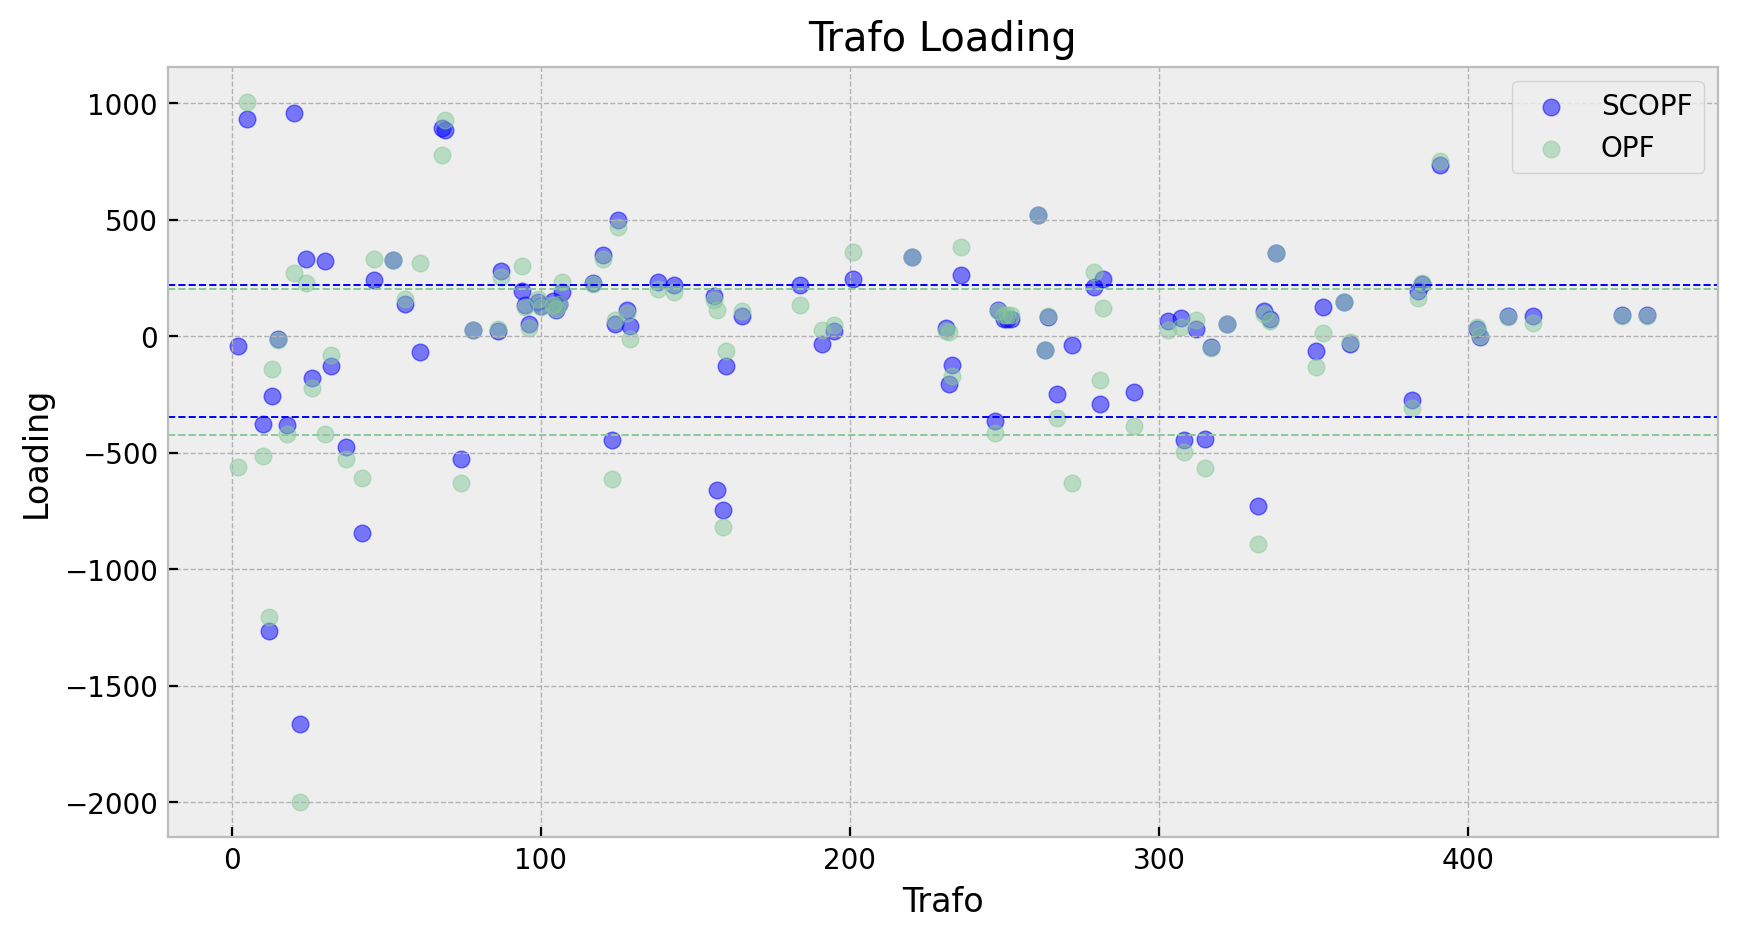

In [108]:
plt.figure(figsize=(10, 5), dpi=200)

xxx = n.transformers.index.to_numpy(dtype='float64')
yyy = n.transformers_t.p0.loc[[now]].to_numpy(dtype='float64')
zzz = o.transformers_t.p0.loc[[now]].to_numpy(dtype='float64')

plt.title("Trafo Loading")
plt.xlabel("Trafo")
plt.ylabel("Loading")

plt.scatter(xxx, yyy, c = 'b', alpha = 0.5, label = 'SCOPF')
plt.scatter(xxx, zzz, c = '#88c999', alpha = 0.5, label = 'OPF')
plt. axhline(y = 220.8176984651823, color = 'b', linestyle = '--', linewidth = .7)
plt. axhline(y = -348.31424497856676, color = 'b', linestyle = '--', linewidth = .7)
plt. axhline(y = 203.8212455, color = '#88c999', linestyle = '--', linewidth = .7)
plt. axhline(y = -422.7401646959375, color = '#88c999', linestyle = '--', linewidth = .7)

plt.legend()
plt.grid(True)
plt.show()

## Finally I take a look at the generation dispatch for both the N-1 base case & the LOPF runs

### I'd expect to see more dispersed generator dispatch, which is required to satisy the N-1 criteria, compare to the base case min. run cost LOPF. And this is indeed the case.
<ul>
<li>Generators in the scigrid are clustered according to the carrier/fuel type.</li>
<li>Hard coal, as well as gas, dispatch is observed in N-1 case, which is not present in LOPF, simply due to the objective of minimizing the sys. cost.</li>
<li>Higher blown coal, as well as other gen., diaptch is also present for the N-1 case.</li>
<li>This basically supstitutes the other cheaper energy resources, which have to be curtailed, in order to meet the N-1 constraints</li>
</ul>

`Hence, the higher production of hard & brown coal, a bit of gas, as well as the other eng. sources, are there to supstitute the other cheaper eng. sources, which need to be curtailed in order to reduces the lines flow, and not the overload the remaining lines in case of a line outage.`

In [246]:
o.generators_t.p.T.groupby(o.generators.carrier).sum().loc[:, [now]].T/1e3

carrier,Brown Coal,Gas,Geothermal,Hard Coal,Multiple,Nuclear,Oil,Other,Run of River,Solar,Storage Hydro,Waste,Wind Offshore,Wind Onshore
snapshot,,,,,,,,,,,,,,
2011-01-01 10:00:00,6.165831,0.0,0.0,0.0,0.0,6.305471,0.0,0.0,3.591,9.449739,1.287,1.3355,2.377127,21.233274


In [245]:
n.generators_t.p.T.groupby(n.generators.carrier).sum().loc[:, [now]].T/1e3

carrier,Brown Coal,Gas,Geothermal,Hard Coal,Multiple,Nuclear,Oil,Other,Run of River,Solar,Storage Hydro,Waste,Wind Offshore,Wind Onshore
snapshot,,,,,,,,,,,,,,
2011-01-01 10:00:00,8.884758,1.180162e-09,0.0,1.639627,0.0,5.425204,0.0,0.084,3.5113,9.068199,1.025833,1.205,1.822417,19.209863


In [263]:
prodA = n.generators_t.p.T.groupby(n.generators.carrier).sum().loc[:, [now]]/1e3

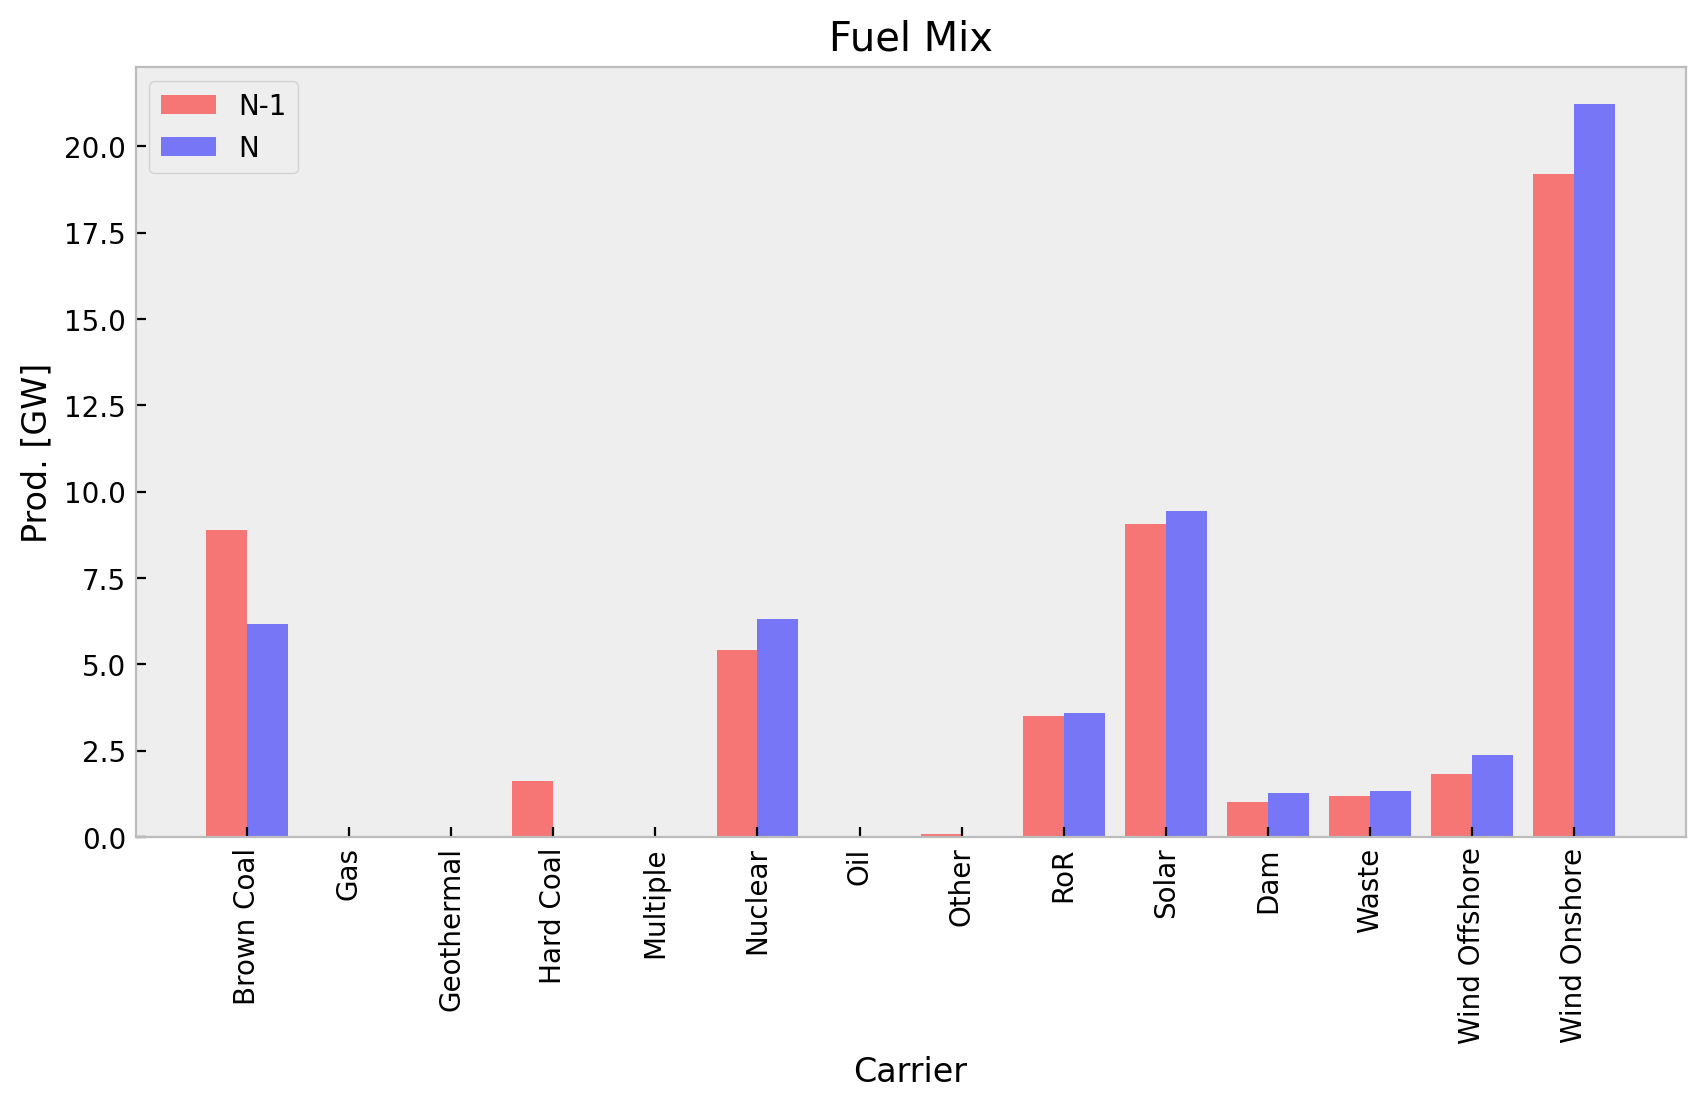

In [319]:
plt.figure(figsize=(10, 5), dpi=200)

carrier = np.array(['Brown Coal', 'Gas', 'Geothermal', 'Hard Coal', 'Multiple', 'Nuclear', 'Oil', 'Other', 'RoR', 'Solar', 'Dam', 'Waste', 'Wind Offshore', 'Wind Onshore'])
ind = np.arange(1, 15, 1)
width = .4

plt.xlabel("Carrier")
plt.xticks(rotation=90)
plt.ylabel("Production [GW]")
plt.title("Fuel Mix")
plt.xticks(ind, ('Brown Coal', 'Gas', 'Geothermal', 'Hard Coal', 'Multiple', 'Nuclear', 'Oil', 'Other', 'RoR', 'Solar', 'Dam', 'Waste', 'Wind Offshore', 'Wind Onshore'))

prodA = n.generators_t.p.T.groupby(n.generators.carrier).sum().loc[:, [now]].to_numpy(dtype='float64')/1e3
prodB = o.generators_t.p.T.groupby(n.generators.carrier).sum().loc[:, [now]].to_numpy(dtype='float64')/1e3
# ax = fig.add_subplot(111)

plt.bar(ind - width/2, prodA[:,0], width, color = "r", alpha = .5, label = 'N-1')
plt.bar(ind + width/2, prodB[:,0], width, color = 'b', alpha = .5, label = 'N')

plt.legend()
plt.grid(False)
plt.show()

In [281]:
prodA[:,0]

array([8.88475761e+03, 1.18016158e-06, 0.00000000e+00, 1.63962732e+03,
       0.00000000e+00, 5.42520368e+03, 0.00000000e+00, 8.40000000e+01,
       3.51130000e+03, 9.06819887e+03, 1.02583337e+03, 1.20500000e+03,
       1.82241652e+03, 1.92098626e+04])

In [ ]:
q = n.generators_t.p.loc[now]

In [109]:
o.generators_t.p.loc[now]

Generator
1 Gas                     0.000000e+00
1 Hard Coal               0.000000e+00
102 Gas                   0.000000e+00
108 Run of River          6.310000e+01
108 Waste                 3.800000e+01
111 Gas                   0.000000e+00
112 Gas                   0.000000e+00
112 Run of River          1.110000e+01
114 Hard Coal             0.000000e+00
115 Brown Coal            1.405075e+03
116 Gas                   0.000000e+00
118 Gas                   0.000000e+00
118 Waste                 1.200000e+01
119 Brown Coal            9.300000e+00
119 Gas                   0.000000e+00
119 Hard Coal             0.000000e+00
121 Brown Coal            2.460000e+01
123_220kV Brown Coal      1.302013e+03
123_220kV Gas             0.000000e+00
126 Gas                   0.000000e+00
126 Oil                   0.000000e+00
127 Brown Coal            1.800000e+03
127 Waste                 2.400000e+01
128_220kV Run of River    3.640000e+01
129_220kV Hard Coal       0.000000e+00
12_220kV Gas   

In [282]:
n.transformers_t.p0.loc[[now]].to_numpy(dtype='float64')

array([[  -41.19797136,   930.01692328,  -376.93979102, -1267.23941245,
         -257.29032441,   -12.62762383,  -382.35143535,   957.67164438,
        -1664.56760099,   330.21866624,  -178.81732186,   321.6252112 ,
         -127.52376363,  -474.13873421,  -845.87898704,   239.27400593,
          328.81379537,   137.52252156,   -68.53191868,   892.29561473,
          883.25763869,  -526.60959232,    27.87088682,    22.33181248,
          280.97579973,   192.55552196,   132.7068009 ,    51.43391911,
          146.33446594,   129.45913494,   152.86125399,   114.05457175,
          136.32823452,   191.36717347,   228.39822043,   348.42986319,
         -445.12880989,    53.38509528,   500.16880028,   110.66073725,
           42.89641256,   230.74555421,   221.46433845,   174.03923042,
         -658.85323209,  -744.58882126,  -128.46003848,    86.63646553,
          221.38603276,   -33.80627502,    21.67511998,   245.77399381,
          340.65873657,    33.83506987,  -204.76191196,  -125.45

In [268]:
vector = np.vectorize(int)
x_ = vector(prodA)

In [258]:
type(prodA)

numpy.ndarray

In [309]:
np.arange(1,15,1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [243]:
len(n.generators.carrier.T)

1423

In [3]:
n.generators_t

NameError: name 'n' is not defined

In [ ]:
p0_test['base']

Line         1      -114.727051
             2       406.740562
             3       354.195129
             4      -870.199344
             5       607.016081
             6        15.782790
             7        68.908090
             8        52.517375
             9       -85.865242
             10     -215.376695
             11     1222.648743
             12     -380.710655
             13      360.359173
             14     -215.143703
             15       40.492852
             16      -86.741751
             17      -57.165950
             18     -421.822332
             19      192.773818
             20      165.041730
             21     -178.817322
             22     -821.238821
             23      -39.534936
             24      -54.227756
             25      749.790532
             26      312.325871
             27     -143.121120
             28    -1001.878131
             29      974.690360
             30      -96.123307
             31      -90.394608
        